We now employ an alternative fitting method based on numerical optimization on the data simulated in the previous section

Imports:

In [1]:
import numpy as np
import numpy.linalg as npl
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from scipy.integrate import solve_ivp

Actual data (for comparison later)

In [2]:
actual_times=np.array([7,14,21])
actual_data=np.array([
    [85.2,11.,2.8],
    [40.3,26.3,28.3],
    [35.3,31.7,29.4]
])
actual_data=np.transpose(np.transpose(actual_data)/np.sum(actual_data,axis=1)) # re-scales so that frequencies sum to 1

equilibrium=actual_data[-1,:] #saves final data point as equilibrium

K=1e7 #carrying capacity
p=0.2 #proportion of injected cells that take hold in initial population
n0=p*np.array([5e5,0,0])/K #initial condition
T=24
names=['NK','int','ILC']

Import data from previous notebook

In [3]:
init_params=np.array(pd.read_csv("init_params.csv"))
init_params=init_params.reshape(len(init_params))

In [4]:
mock_df=pd.read_csv("mock_df.csv")

Define ODE as before

In [5]:
def ODE(n,growth_rates,switch_rates,competition):
    '''
    n is number of cells (scaled) with dimension d;
    growth_rates as d x 1 vector;
    switch_rates as d x d matrix;
    competition kernel as d x d matrix;
    '''
    dim=len(n)
    dndt=np.zeros(dim)
    for i in range(dim):
        dndt[i]=n[i]*(growth_rates[i]-np.sum(switch_rates[i,:])-competition[i,:].dot(n))+switch_rates[:,i].dot(n)
    return dndt

In [6]:
def simulate_ODE(params, n0, T):
    growth_rates=params[:3]
    competition=params[3:12].reshape((3,3))
    switch_rates=np.array([
        [0,params[12],0],
        [0,0,params[13]],
        [0,0,0]
        ])
    rhs=lambda t, n: ODE(n,growth_rates,switch_rates,competition)
    sim=solve_ivp(rhs,(0,T),n0)
    return sim

Define loss function and objective function (which is just the loss function applied to the specific data)

In [7]:
def loss_function(params,data,timepoints,n0,T):
    sim=simulate_ODE(params,n0,T)
    return np.sum((data-np.array([sim['y'][:,np.argmin(abs(sim['t']-t))]for t in timepoints]))**2)

In [8]:
mock_data_array=np.array(mock_df[names])
mock_timepoints=np.array(mock_df['t'])

In [9]:
obj=lambda params: loss_function(params,mock_data_array,mock_timepoints,n0,T)

Apply different optimization methods to achieve optimal parameter

In [10]:
opt_bounds=[(0,None)]*14

In [11]:
from scipy.optimize import minimize

In [12]:
theta0=np.round(init_params,0)
colnames=['Method','Gradient approx','r_NK','r_int','r_ILC','c_NK,NK','c_NK,int','c_NK,ILC','c_int,NK','c_int,int','c_int,ILC','c_ILC,NK','c_ILC,int','c_ILC,ILC',
         's_NK,int','s_int,ILC','Message','Success','RMSE_sim','RMSE_actual']
opt_outputs=np.zeros(len(colnames))
methods=['TNC','L-BFGS-B']
jacs=['2-point','3-point']
maxit=[99,300,300,300] #cannot get TNC with 2-point to run with more than 99 iteration. Did not find cause
count=0

for m in methods:
    for j in jacs:
        min_result=min_result=minimize(obj,x0=theta0,method=m,jac=j,bounds=opt_bounds,options={'maxiter':maxit[count]})
        opt_params=min_result['x']
        mess=min_result['message']
        RMSE_simdata=np.sqrt(min_result['fun']/np.product(mock_data_array.shape))
        conv_success=min_result['success']
        sim=simulate_ODE(opt_params,n0,T)
        RMSE_actual=np.sqrt(np.sum((actual_data-[(sim['y']/np.sum(sim['y'],axis=0))[:,np.argmin(abs(sim['t']-t))]for t in actual_times])**2)/(len(actual_times)*len(actual_data[0,:])))
        count+=1
        opt_outputs=np.vstack((opt_outputs,np.concatenate(([m],[j],opt_params,[mess],[conv_success],[RMSE_simdata],[RMSE_actual]))))
        print('Method '+m+' completed.')

#We run COBYLA and trust-constr method separately since the syntax is different
methods=['COBYLA']
for m in methods:
    min_result=minimize(obj,x0=theta0,method=m,constraints=({'type':'ineq','fun':lambda x: x}))
    opt_params=min_result['x']
    mess=min_result['message']
    RMSE_simdata=np.sqrt(min_result['fun']/np.product(mock_data_array.shape))
    conv_success=min_result['success']
    sim=simulate_ODE(opt_params,n0,T)
    RMSE_actual=np.sqrt(np.sum((actual_data-[(sim['y']/np.sum(sim['y'],axis=0))[:,np.argmin(abs(sim['t']-t))]for t in actual_times])**2)/(len(actual_times)*len(actual_data[0,:])))
    opt_outputs=np.vstack((opt_outputs,np.concatenate(([m],['Not applicable'],opt_params,[mess],[conv_success],[RMSE_simdata],[RMSE_actual]))))
    print('Method '+m+' completed.')

min_result=minimize(obj,x0=theta0,method='trust-constr',bounds=opt_bounds)
opt_params=min_result['x']
mess=min_result['message']
RMSE_simdata=np.sqrt(min_result['fun']/np.product(mock_data_array.shape))
conv_success=min_result['success']
sim=simulate_ODE(opt_params,n0,T)
RMSE_actual=np.sqrt(np.sum((actual_data-[(sim['y']/np.sum(sim['y'],axis=0))[:,np.argmin(abs(sim['t']-t))]for t in actual_times])**2)/(len(actual_times)*len(actual_data[0,:])))
opt_outputs=np.vstack((opt_outputs,np.concatenate((['trust-constr'],['Not applicable'],opt_params,[mess],[conv_success],[RMSE_simdata],[RMSE_actual]))))        
print('Method trust-constr completed.')

opt_outputs_df=pd.DataFrame(opt_outputs[1:],columns=colnames)

Method TNC completed.
Method TNC completed.
Method L-BFGS-B completed.
Method L-BFGS-B completed.
Method COBYLA completed.


C:\Users\carlw\anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


Method trust-constr completed.


In [13]:
num_cols=np.concatenate((colnames[2:16],colnames[18:]))
for c in num_cols:
    opt_outputs_df[c]=opt_outputs_df[c].apply(lambda x: float(x))

In [14]:
opt_outputs_df

,Method,Gradient approx,r_NK,r_int,r_ILC,"c_NK,NK","c_NK,int","c_NK,ILC","c_int,NK","c_int,int","c_int,ILC","c_ILC,NK","c_ILC,int","c_ILC,ILC","s_NK,int","s_int,ILC",Message,Success,RMSE_sim,RMSE_actual
0,TNC,2-point,1.011180,1.001687,1.003941,2.898922,0.000000,0.000000,0.013321,3.028572,0.000000,0.000000,1.000946,3.003094,0.000122,0.001102,Max. number of function evaluations reached,False,0.088809,0.126083
1,TNC,3-point,1.032314,1.078824,1.094140,2.757140,0.003950,0.000000,0.011833,3.209414,0.022479,0.006716,0.909411,2.743649,0.001324,0.009723,Converged (|f_n-f_(n-1)| ~= 0),True,0.024391,0.056109
2,L-BFGS-B,2-point,1.106867,0.968572,1.130912,2.971451,0.008926,0.006007,0.011786,3.012934,0.008738,0.000000,0.952133,2.964323,0.002623,0.004917,ABNORMAL_TERMINATION_IN_LNSRCH,False,0.023368,0.039772
3,L-BFGS-B,3-point,1.089171,0.967915,1.053637,2.974817,0.000000,0.000000,0.010264,3.008367,0.003782,0.000007,0.980736,2.986493,0.002375,0.029507,ABNORMAL_TERMINATION_IN_LNSRCH,False,0.031847,0.034856
4,COBYLA,Not applicable,1.021910,0.897125,1.039799,2.815926,0.000115,0.003508,0.014116,3.029431,0.078350,0.063534,1.046714,3.002975,0.004856,0.012365,Optimization terminated successfully.,True,0.033565,0.072485
5,trust-constr,Not applicable,1.481480,2.693152,0.054358,5.436847,2.727398,2.790813,2.749400,5.245472,2.324920,2.710113,2.200409,6.073141,5.516193,1.145878,`xtol` termination condition is satisfied.,True,0.212506,0.421462


Choose the parameter vector from the output which minimizes the objective function. Simulate system with these parameters and the parameters from the varied growth rates model from the previous section, and compare:

In [15]:
opt_params=np.array(opt_outputs_df.iloc[np.argmin(opt_outputs_df['RMSE_sim']),2:16])
sim=simulate_ODE(opt_params,n0,T)
sim2=simulate_ODE(init_params,n0,T)
RMSE_sim=np.min(opt_outputs_df['RMSE_sim'])
RMSE_sim2=np.sqrt(obj(init_params)/np.product(mock_data_array.shape))
RMSE=np.sqrt(np.sum((actual_data-[(sim['y']/np.sum(sim['y'],axis=0))[:,np.argmin(abs(sim['t']-t))]for t in actual_times])**2)/(len(actual_times)*len(actual_data[0,:])))
RMSE2=np.sqrt(np.sum((actual_data-[(sim2['y']/np.sum(sim2['y'],axis=0))[:,np.argmin(abs(sim2['t']-t))]for t in actual_times])**2)/(len(actual_times)*len(actual_data[0,:])))

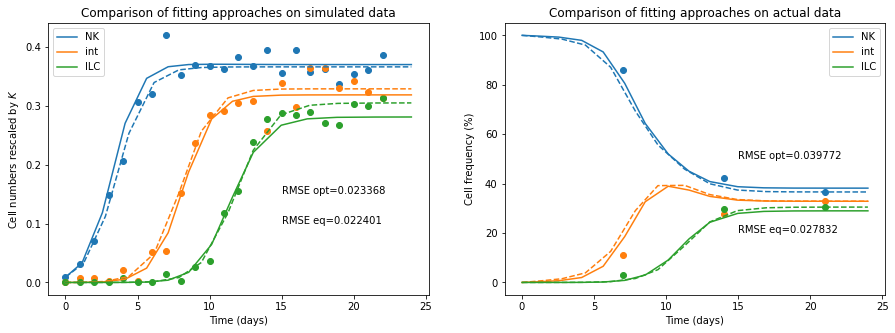

In [16]:
sim=simulate_ODE(opt_params,n0,T)
sim2=simulate_ODE(init_params,n0,T)
colors=['tab:blue','tab:orange','tab:green']

fig, axs=plt.subplots(1,2)
fig.set_figheight(5)
fig.set_figwidth(15)
for i in range(3):
    axs[0].plot(sim['t'],sim['y'][i],label=names[i],color=colors[i])
    axs[0].plot(sim2['t'],sim2['y'][i],color=colors[i],linestyle='dashed')
    axs[0].scatter(mock_timepoints,mock_data_array[:,i],marker='o')  
axs[0].legend()
axs[0].set_xlabel('Time (days)')
axs[0].set_ylabel('Cell numbers rescaled by $K$')
axs[0].set_title('Comparison of fitting approaches on simulated data')
axs[0].text(15,0.15,'RMSE opt=%f'%(RMSE_sim))
axs[0].text(15,0.1,'RMSE eq=%f'%(RMSE_sim2))

for i in range(3):
    axs[1].plot(sim['t'],100*(sim['y']/np.sum(sim['y'],axis=0))[i],label=names[i],color=colors[i])
    axs[1].plot(sim2['t'],100*(sim2['y']/np.sum(sim2['y'],axis=0))[i],color=colors[i],linestyle='dashed')
    axs[1].scatter(actual_times,100*actual_data[:,i],marker='o')
axs[1].legend()
axs[1].set_xlabel('Time (days)')
axs[1].set_ylabel('Cell frequency (%)')
axs[1].set_title('Comparison of fitting approaches on actual data')
axs[1].text(15,50,'RMSE opt=%f'%(RMSE))
axs[1].text(15,20,'RMSE eq=%f'%(RMSE2))
plt.show()